In [1]:
from typing import List, Optional, Callable, Iterable
from itertools import islice
import json
import pickle
import datetime
import pandas as pd
import torch_metrics

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import torch
import torch.nn as nn
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.torch.distributions import StudentTOutput
from gluonts.model.forecast_generator import DistributionForecastGenerator

import lightning.pytorch as pl
from gluonts.dataset.loader import TrainDataLoader
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddObservedValuesIndicator,
    InstanceSplitter,
    ExpectedNumInstanceSampler,
    TestSplitSampler,
)
from gluonts.evaluation import make_evaluation_predictions, Evaluator
# from gluonts.torch.model.tft.module import TemporalFusionTransformerModel
# from gluonts.mx.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.dataset.common import (
    FileDataset, ListDataset, TrainDatasets,
    CategoricalFeatureInfo, BasicFeatureInfo,
)
from gluonts.dataset.loader import TrainDataLoader, InferenceDataLoader
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from datasets import Dataset, Features, Value, Sequence
from gluonts.dataset.common import MetaData
from sklearn.neighbors import NearestNeighbors


/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.chdir(os.path.expanduser("."))

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pywt


In [4]:
import os
import csv
import pickle

import numpy as np


def get_adjacency_matrix(distance_df_filename: str, num_of_vertices: int, id_filename: str = None) -> tuple:
    """Generate adjacency matrix.

    Args:
        distance_df_filename (str): path of the csv file contains edges information
        num_of_vertices (int): number of vertices
        id_filename (str, optional): id filename. Defaults to None.

    Returns:
        tuple: two adjacency matrix.
            np.array: connectivity-based adjacency matrix A (A[i, j]=0 or A[i, j]=1)
            np.array: distance-based adjacency matrix A
    """

    if "npy" in distance_df_filename:
        adj_mx = np.load(distance_df_filename)
        return adj_mx, None
    else:
        adjacency_matrix_connectivity = np.zeros((int(num_of_vertices), int(
            num_of_vertices)), dtype=np.float32)
        adjacency_matrix_distance = np.zeros((int(num_of_vertices), int(num_of_vertices)),
                                             dtype=np.float32)
        if id_filename:
            # the id in the distance file does not start from 0, so it needs to be remapped
            with open(id_filename, "r") as f:
                id_dict = {int(i): idx for idx, i in enumerate(
                    f.read().strip().split("\n"))}  # map node idx to 0-based index (start from 0)
            with open(distance_df_filename, "r") as f:
                f.readline()  # omit the first line
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    adjacency_matrix_connectivity[id_dict[i], id_dict[j]] = 1
                    adjacency_matrix_connectivity[id_dict[j], id_dict[i]] = 1
                    adjacency_matrix_distance[id_dict[i],
                                              id_dict[j]] = distance
                    adjacency_matrix_distance[id_dict[j],
                                              id_dict[i]] = distance
            return adjacency_matrix_connectivity, adjacency_matrix_distance
        else:
            # ids in distance file start from 0
            with open(distance_df_filename, "r") as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    adjacency_matrix_connectivity[i, j] = 1
                    adjacency_matrix_connectivity[j, i] = 1
                    adjacency_matrix_distance[i, j] = distance
                    adjacency_matrix_distance[j, i] = distance
            return adjacency_matrix_connectivity, adjacency_matrix_distance


def generate_adj_pems04():
    distance_df_filename, num_of_vertices = "/home/seyed/PycharmProjects/step/STEP/datasets/raw_data/PEMS04/PEMS04.csv", 307
    if os.path.exists(distance_df_filename.split(".", maxsplit=1)[0] + ".txt"):
        id_filename = distance_df_filename.split(".", maxsplit=1)[0] + ".txt"
    else:
        id_filename = None
    adj_mx, distance_mx = get_adjacency_matrix(
        distance_df_filename, num_of_vertices, id_filename=id_filename)
    # the self loop is missing
    add_self_loop = True
    if add_self_loop:
        print("adding self loop to adjacency matrices.")
        adj_mx = adj_mx + np.identity(adj_mx.shape[0])
        distance_mx = distance_mx + np.identity(distance_mx.shape[0])
    else:
        print("kindly note that there is no self loop in adjacency matrices.")
    return adj_mx, distance_mx


In [5]:
adj_mx, distance_mx = generate_adj_pems04()

adding self loop to adjacency matrices.


In [6]:
KNN = 5
df_pems4 = np.load("/home/seyed/PycharmProjects/step/STEP/datasets/raw_data/PEMS04/PEMS04.npz")["data"]
df_pems4_new = pd.DataFrame(df_pems4[:,:,0])
neigh = NearestNeighbors(n_neighbors=KNN)
neigh.fit(df_pems4_new.T.values)
k_nn = neigh.kneighbors_graph().toarray()
k_nn = k_nn + np.eye(k_nn.shape[0])

In [7]:
adj_tensor = torch.tensor(adj_mx, dtype=torch.float32)

In [8]:
data_set = torch.tensor(df_pems4_new.values, dtype=torch.float32)

In [9]:
data_set_train = data_set[:int(data_set.shape[0] * 0.8)]
data_set_test = data_set[int(data_set.shape[0] * 0.8):]

In [10]:
def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

In [11]:
import pandas as pd
from scipy.fft import fft


def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = 300
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()

def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    print("T", T)
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def plot_fft_plus_power(time, signal):
    dt = 300
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_values[0] = 0.0
    ax.plot(f_values, abs(fft_values), 'r-', label='Fourier Transform')
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    # for freq, coef in zip(f_values, fft_power):
    #     print("FFT Freq:",freq, "HZ", "Coef:", coef)
    # ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    # ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    plt.show()

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

In [13]:
# time_values = pd.date_range(start="2018-01-01", periods=data_set_train.shape[0], freq="5min").values

In [14]:
# adj_tensor.nonzero()[:3][:, 1].tolist()

In [15]:
# x = mdates.date2num(time_values)
# fig, ax = plt.subplots(figsize=(12, 6))
# for ind in adj_tensor.nonzero()[:3][:, 1].tolist():
#     ax.plot(x, data_set_train.numpy()[:,ind], label='Signal {}'.format(ind))

# # Format the x-axis ticks
# date_formatter = mdates.DateFormatter("%Y-%m-%d %H:%M")
# ax.xaxis.set_major_formatter(date_formatter)

# # Rotate the x-axis tick labels
# plt.xticks(rotation=45)

# # Set labels and title
# ax.set_xlabel('Time')
# ax.set_ylabel('Value')
# ax.set_title('Time-based Plot')

# # Adjust the x-axis limits to include all data points
# plt.xlim([mdates.date2num(time_values[0]), mdates.date2num(time_values[-1])])
# plt.legend()
# # Show the plot

# plot_signal_plus_average(time_values, data_set_train.numpy()[:,0], average_over = 5)


In [16]:
1/300

0.0033333333333333335

In [17]:
scales = np.arange(1, 128)

# for ind in adj_tensor.nonzero()[:3][:, 1].tolist():
#     # ax.plot(x, data_set_train.numpy()[:,ind], label='Signal {}'.format(ind))
#     plot_signal_plus_average(time_values, data_set_train.numpy()[:,ind])
#     # plot_fft_plus_power(time_values, data_set_train.numpy()[:,ind])
#     plot_wavelet(time_values, data_set_train.numpy()[:,ind], scales)



In [18]:
# plot_signal_plus_average(time_values, data_set_train.numpy()[:,66])
# plot_fft_plus_power(time_values, data_set_train.numpy()[:,66])
# # plot_wavelet(time_values, data_set_train.numpy()[:,66], scales)

In [19]:
from math import ceil, floor

from pywt._extensions._pywt import (
    ContinuousWavelet,
    DiscreteContinuousWavelet,
    Wavelet,
    _check_dtype,
)
from pywt._functions import integrate_wavelet, scale2frequency
from pywt._utils import AxisError

__all__ = ["cwt"]


import numpy as np

try:
    # Prefer scipy.fft (new in SciPy 1.4)
    import scipy.fft
    fftmodule = scipy.fft
    next_fast_len = fftmodule.next_fast_len
except ImportError:
    try:
        import scipy.fftpack
        fftmodule = scipy.fftpack
        next_fast_len = fftmodule.next_fast_len
    except ImportError:
        fftmodule = np.fft

        # provide a fallback so scipy is an optional requirement
        def next_fast_len(n):
            """Round up size to the nearest power of two.

            Given a number of samples `n`, returns the next power of two
            following this number to take advantage of FFT speedup.
            This fallback is less efficient than `scipy.fftpack.next_fast_len`
            """
            return 2**ceil(np.log2(n))


def np_cwt(data, scales, wavelet, sampling_period=1., method='conv', axis=-1):
    """
    """

    # accept array_like input; make a copy to ensure a contiguous array
    dt = _check_dtype(data)
    data = np.asarray(data, dtype=dt)
    dt_cplx = np.result_type(dt, np.complex64)
    if not isinstance(wavelet, (ContinuousWavelet, Wavelet)):
        wavelet = DiscreteContinuousWavelet(wavelet)

    scales = np.atleast_1d(scales)
    if np.any(scales <= 0):
        raise ValueError("`scales` must only include positive values")

    if not np.isscalar(axis):
        raise AxisError("axis must be a scalar.")

    dt_out = dt_cplx if wavelet.complex_cwt else dt
    out = np.empty((np.size(scales),) + data.shape, dtype=dt_out)
    precision = 10
    int_psi, x = integrate_wavelet(wavelet, precision=precision)
    int_psi = np.conj(int_psi) if wavelet.complex_cwt else int_psi

    # convert int_psi, x to the same precision as the data
    dt_psi = dt_cplx if int_psi.dtype.kind == 'c' else dt
    int_psi = np.asarray(int_psi, dtype=dt_psi)
    x = np.asarray(x, dtype=data.real.dtype)

    if method == 'fft':
        size_scale0 = -1
        fft_data = None
    elif method != "conv":
        raise ValueError("method must be 'conv' or 'fft'")

    if data.ndim > 1:
        # move axis to be transformed last (so it is contiguous)
        data = data.swapaxes(-1, axis)

        # reshape to (n_batch, data.shape[-1])
        data_shape_pre = data.shape
        data = data.reshape((-1, data.shape[-1]))

    for i, scale in enumerate(scales):
        step = x[1] - x[0]
        j = np.arange(scale * (x[-1] - x[0]) + 1) / (scale * step)
        j = j.astype(int)  # floor
        if j[-1] >= int_psi.size:
            j = np.extract(j < int_psi.size, j)
        int_psi_scale = int_psi[j][::-1]

        if method == 'conv':
            if data.ndim == 1:
                conv = np.convolve(data, int_psi_scale)
            else:
                # batch convolution via loop
                conv_shape = list(data.shape)
                conv_shape[-1] += int_psi_scale.size - 1
                conv_shape = tuple(conv_shape)
                conv = np.empty(conv_shape, dtype=dt_out)
                for n in range(data.shape[0]):
                    conv[n, :] = np.convolve(data[n], int_psi_scale)
        else:
            # The padding is selected for:
            # - optimal FFT complexity
            # - to be larger than the two signals length to avoid circular
            #   convolution
            size_scale = next_fast_len(
                data.shape[-1] + int_psi_scale.size - 1
            )
            if size_scale != size_scale0:
                # Must recompute fft_data when the padding size changes.
                fft_data = fftmodule.fft(data, size_scale, axis=-1)
            size_scale0 = size_scale
            fft_wav = fftmodule.fft(int_psi_scale, size_scale, axis=-1)
            conv = fftmodule.ifft(fft_wav * fft_data, axis=-1)
            conv = conv[..., :data.shape[-1] + int_psi_scale.size - 1]

        coef = - np.sqrt(scale) * np.diff(conv, axis=-1)
        if out.dtype.kind != 'c':
            coef = coef.real
        # transform axis is always -1 due to the data reshape above
        d = (coef.shape[-1] - data.shape[-1]) / 2.
        if d > 0:
            coef = coef[..., floor(d):-ceil(d)]
        elif d < 0:
            raise ValueError(
                f"Selected scale of {scale} too small.")
        if data.ndim > 1:
            # restore original data shape and axis position
            coef = coef.reshape(data_shape_pre)
            coef = coef.swapaxes(axis, -1)
        out[i, ...] = coef

    frequencies = scale2frequency(wavelet, scales, precision)
    if np.isscalar(frequencies):
        frequencies = np.array([frequencies])
    frequencies /= sampling_period
    return out, frequencies

waveletname = 'cmor'
# coeff, freq = pywt.cwt(data_set_train.numpy()[:,66], scales, waveletname, 1)

coeff, freq = np_cwt(data_set_train.numpy()[:,66], scales, waveletname, 1)


/tmp/ipykernel_18856/2717805501.py:50: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


In [20]:
import pywt

In [21]:
np.abs(coeff)

array([[  8.046357 ,   4.6424494,   5.6546125, ...,   2.50838  ,
          2.238198 ,   2.0106585],
       [ 10.910137 ,   3.9373527,   6.715363 , ...,   5.5662246,
          5.1803594,   5.6498666],
       [ 12.730752 ,   9.030173 ,   7.253589 , ...,   8.261536 ,
          9.556228 ,   9.440023 ],
       ...,
       [266.89328  , 273.20792  , 102.76913  , ..., 430.00803  ,
        417.41602  , 417.93207  ],
       [249.75821  , 253.03252  , 288.40115  , ..., 436.18634  ,
        427.21426  , 423.6489   ],
       [300.89615  , 274.28525  , 297.38922  , ..., 444.45218  ,
        436.32437  , 432.75385  ]], dtype=float32)

In [22]:
# from pywt._extensions._pywt import (
#     ContinuousWavelet,
#     DiscreteContinuousWavelet,
#     Wavelet,
#     _check_dtype,
# )
# import torch.nn.functional as F
# from pywt._functions import integrate_wavelet, scale2frequency
# _NEXT_FAST_LEN = {}


# def next_fast_len(size):
#     """
#     Returns the next largest number ``n >= size`` whose prime factors are all
#     2, 3, or 5. These sizes are efficient for fast fourier transforms.
#     Equivalent to :func:`scipy.fftpack.next_fast_len`.

#     Implementation from pyro

#     :param int size: A positive number.
#     :returns: A possibly larger number.
#     :rtype int:
#     """
#     try:
#         return _NEXT_FAST_LEN[size]
#     except KeyError:
#         pass

#     assert isinstance(size, int) and size > 0
#     next_size = size
#     while True:
#         remaining = next_size
#         for n in (2, 3, 5):
#             while remaining % n == 0:
#                 remaining //= n
#         if remaining == 1:
#             _NEXT_FAST_LEN[size] = next_size
#             return next_size
#         next_size += 1

    
# import torch.utils
# fftmodule = torch.fft
# AxisError: type[Exception]

# def kind(dtype):
#     if dtype == torch.float32:
#         return "f"
#     elif dtype == torch.int32:
#         return "i"
#     elif dtype == torch.uint8:
#         return "u"
#     elif dtype == torch.complex64:
#         return "c"
#     elif dtype == torch.bool:
#         return "b"


# def _cwt(data, scales, wavelet, sampling_period=1., method='conv', axis=-1):
#     """
#     cwt(data, scales, wavelet)

#     One dimensional Continuous Wavelet Transform.

#     Parameters
#     ----------
#     data : array_like
#         Input signal
#     scales : array_like
#         The wavelet scales to use. One can use
#         ``f = scale2frequency(wavelet, scale)/sampling_period`` to determine
#         what physical frequency, ``f``. Here, ``f`` is in hertz when the
#         ``sampling_period`` is given in seconds.
#     wavelet : Wavelet object or name
#         Wavelet to use
#     sampling_period : float
#         Sampling period for the frequencies output (optional).
#         The values computed for ``coefs`` are independent of the choice of
#         ``sampling_period`` (i.e. ``scales`` is not scaled by the sampling
#         period).
#     method : {'conv', 'fft'}, optional
#         The method used to compute the CWT. Can be any of:
#             - ``conv`` uses ``numpy.convolve``.
#             - ``fft`` uses frequency domain convolution.
#             - ``auto`` uses automatic selection based on an estimate of the
#               computational complexity at each scale.

#         The ``conv`` method complexity is ``O(len(scale) * len(data))``.
#         The ``fft`` method is ``O(N * log2(N))`` with
#         ``N = len(scale) + len(data) - 1``. It is well suited for large size
#         signals but slightly slower than ``conv`` on small ones.
#     axis: int, optional
#         Axis over which to compute the CWT. If not given, the last axis is
#         used.

#     Returns
#     -------
#     coefs : array_like
#         Continuous wavelet transform of the input signal for the given scales
#         and wavelet. The first axis of ``coefs`` corresponds to the scales.
#         The remaining axes match the shape of ``data``.
#     frequencies : array_like
#         If the unit of sampling period are seconds and given, then frequencies
#         are in hertz. Otherwise, a sampling period of 1 is assumed.

#     Notes
#     -----
#     Size of coefficients arrays depends on the length of the input array and
#     the length of given scales.

#     """

#     # accept array_like input; make a copy to ensure a contiguous array
#     dt = torch.get_default_dtype()
#     data = torch.tensor(data, dtype=dt)
#     dt_cplx = torch.complex64
#     if not isinstance(wavelet, (ContinuousWavelet, Wavelet)):
#         wavelet = DiscreteContinuousWavelet(wavelet)
#     scales = torch.tensor(scales, dtype=dt)
#     scales = torch.atleast_1d(scales)
#     if torch.any(scales <= 0):
#         raise ValueError("`scales` must only include positive values")

#     dt_out = dt_cplx if wavelet.complex_cwt else dt
#     out = torch.empty((torch.numel(scales),) + data.shape, dtype=dt_out)
#     precision = 10
#     int_psi, x = integrate_wavelet(wavelet, precision=precision)
#     int_psi = torch.conj(torch.tensor(int_psi)) if wavelet.complex_cwt else int_psi

#     # convert int_psi, x to the same precision as the data
#     dt_psi = dt_cplx if kind(int_psi.dtype) == 'c' else dt
#     int_psi = torch.tensor(int_psi, dtype=dt_psi)
#     x = torch.tensor(x, dtype=data.real.dtype)

#     if method == 'fft':
#         size_scale0 = -1
#         fft_data = None
#     elif method != "conv":
#         raise ValueError("method must be 'conv' or 'fft'")

#     if data.ndim > 1:
#         # move axis to be transformed last (so it is contiguous)
#         data = data.swapaxes(-1, axis)

#         # reshape to (n_batch, data.shape[-1])
#         data_shape_pre = data.shape
#         data = data.reshape((-1, data.shape[-1]))

#     for i, scale in enumerate(scales):
#         step = x[1] - x[0]
#         j = torch.arange(scale * (x[-1] - x[0]) + 1) / (scale * step)
#         j = j.to(int)  # floor
#         if j[-1] >= int_psi.numel():
#             j = torch.masked_select(j, j < int_psi.numel())
#         int_psi_scale = int_psi[j][:-1]

#         if method == 'conv':
#             if data.ndim == 1:
#                 conv = F.conv1d(data.unsqueeze(0).unsqueeze(0), int_psi_scale.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
#             else:
#                 # batch convolution via loop
#                 conv_shape = list(data.shape)
#                 conv_shape[-1] += int_psi_scale.numel() - 1
#                 conv_shape = tuple(conv_shape)
#                 conv = torch.empty(conv_shape, dtype=dt_out)
#                 for n in range(data.shape[0]):
#                     conv[n, :] = np.convolve(data[n], int_psi_scale)
#         else:
#             # The padding is selected for:
#             # - optimal FFT complexity
#             # - to be larger than the two signals length to avoid circular
#             #   convolution
#             size_scale = next_fast_len(
#                 data.shape[-1] + int_psi_scale.numel() - 1
#             )
#             if size_scale != size_scale0:
#                 # Must recompute fft_data when the padding size changes.
#                 fft_data = fftmodule.fft(data, size_scale, axis=-1)
#             size_scale0 = size_scale
#             fft_wav = fftmodule.fft(int_psi_scale, size_scale, axis=-1)
#             conv = fftmodule.ifft(fft_wav * fft_data, axis=-1)
#             conv = conv[..., :data.shape[-1] + int_psi_scale.size - 1]

#         coef = - torch.sqrt(scale) * torch.diff(conv, axis=-1)
#         if kind(out.dtype) != 'c':
#             coef = coef.real
#         # transform axis is always -1 due to the data reshape above
#         d = (coef.shape[-1] - data.shape[-1]) / 2.
#         if d > 0:
#             coef = coef[..., torch.floor(d):-torch.ceil(d)]
#         elif d < 0:
#             raise ValueError(
#                 f"Selected scale of {scale} too small.")
#         if data.ndim > 1:
#             # restore original data shape and axis position
#             coef = coef.reshape(data_shape_pre)
#             coef = coef.swapaxes(axis, -1)
#         out[i, ...] = coef

#     frequencies = scale2frequency(wavelet, scales, precision)
#     is_scalar = lambda item: torch.is_tensor(item) and item.numel() == 1
#     if is_scalar(frequencies):
#         frequencies = torch.tensor([frequencies])
#     frequencies /= sampling_period
#     return out, frequencies


In [23]:
device = "cuda:0"

In [24]:
from torch.utils.data import Dataset, DataLoader
import pickle


def load_pkl(pickle_file: str) -> object:
    """Load pickle data.

    Args:
        pickle_file (str): file path

    Returns:
        object: loaded objected
    """

    try:
        with open(pickle_file, "rb") as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError:
        with open(pickle_file, "rb") as f:
            pickle_data = pickle.load(f, encoding="latin1")
    except Exception as e:
        print("Unable to load data ", pickle_file, ":", e)
        raise
    return pickle_data


class TimeSeriesForecastingDataset(Dataset):
    """Time series forecasting dataset."""

    def __init__(self, data_file_path: str, index_file_path: str, mode: str) -> None:
        super().__init__()
        assert mode in ["train", "val", "test"], "error mode"
        self._check_if_file_exists(data_file_path, index_file_path)
        # read raw data (normalized)
        data = np.load(data_file_path)
        processed_data = data["data"]
        self.labels = self.data = torch.from_numpy(processed_data).float()
        # read index
        self.index = np.load(index_file_path)[mode]
        # self.precomputed_wavelets = self._precompute_wavelets()

    def _precompute_wavelets(self):
        """Precompute wavelet transforms for the entire dataset."""
        waveletname = 'cmor'
        scales = np.arange(1, 128)
        precomputed_wavelets = []
        new_history = torch.zeros(127, self.data.shape[0], self.data.shape[1], self.data.shape[2])
        for sensor in range(self.data.shape[1]):
            for channel in range(self.data.shape[2]):
                coeff, _ = pywt.cwt(self.data[:, sensor, channel].numpy(), scales, waveletname, 1)
                new_history[:, :, sensor, channel] = torch.tensor(np.abs(coeff), device=self.data.device)  # L x N x C
            precomputed_wavelets.append(new_history[..., 0].permute(1, 2, 0))
        self.data = new_history

    def _check_if_file_exists(self, data_file_path: str, index_file_path: str):
        """Check if data file and index file exist.

        Args:
            data_file_path (str): data file path
            index_file_path (str): index file path

        Raises:
            FileNotFoundError: no data file
            FileNotFoundError: no index file
        """

        if not os.path.isfile(data_file_path):
            raise FileNotFoundError("BasicTS can not find data file {0}".format(data_file_path))
        if not os.path.isfile(index_file_path):
            raise FileNotFoundError("BasicTS can not find index file {0}".format(index_file_path))

    def __getitem__(self, index: int) -> tuple:
        """Get a sample.

        Args:
            index (int): the iteration index (not the self.index)

        Returns:
            tuple: (future_data, history_data), where the shape of each is L x N x C.
        """

        idx = list(self.index[index])
        if isinstance(idx[0], np.int64):
            # continuous index
            history_data = self.data[idx[1]:idx[2]][..., 0]
            future_data = self.labels[idx[1]:idx[2]][..., 0]
        else:
            # discontinuous index or custom index
            # NOTE: current time $t$ should not included in the index[0]
            history_index = idx[0]    # list
            assert idx[1] not in history_index, "current time t should not included in the idx[0]"
            history_index.append(idx[1])
            history_data = self.data[history_index]
            future_data = self.labels[idx[1], idx[2]]
        return future_data, history_data


    def __len__(self):
        """Dataset length

        Returns:
            int: dataset length
        """

        return len(self.index)


In [25]:
dataset_train = TimeSeriesForecastingDataset("/home/seyed/Downloads/data.npz", "/home/seyed/Downloads/index.npz", "train")
dataset_valid = TimeSeriesForecastingDataset("/home/seyed/Downloads/data.npz", "/home/seyed/Downloads/index.npz", "val")
train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, pin_memory=True)
valid_loader = DataLoader(dataset_valid, batch_size=16, shuffle=False, pin_memory=True)

In [56]:
import torch.nn as nn
import torch
from torchinfo import summary


class AttentionLayer(nn.Module):
    """Perform attention across the -2 dim (the -1 dim is `model_dim`).

    Make sure the tensor is permuted to correct shape before attention.

    E.g.
    - Input shape (batch_size, in_steps, num_nodes, model_dim).
    - Then the attention will be performed across the nodes.

    Also, it supports different src and tgt length.

    But must `src length == K length == V length`.

    """

    def __init__(self, model_dim, num_heads=8, mask=False):
        super().__init__()

        self.model_dim = model_dim
        self.num_heads = num_heads
        self.mask = mask

        self.head_dim = model_dim // num_heads

        self.FC_Q = nn.Linear(model_dim, model_dim)
        self.FC_K = nn.Linear(model_dim, model_dim)
        self.FC_V = nn.Linear(model_dim, model_dim)

        self.out_proj = nn.Linear(model_dim, model_dim)

    def forward(self, query, key, value):
        # Q    (batch_size, ..., tgt_length, model_dim)
        # K, V (batch_size, ..., src_length, model_dim)
        batch_size = query.shape[0]
        tgt_length = query.shape[-2]
        src_length = key.shape[-2]

        query = self.FC_Q(query)
        key = self.FC_K(key)
        value = self.FC_V(value)

        # Qhead, Khead, Vhead (num_heads * batch_size, ..., length, head_dim)
        query = torch.cat(torch.split(query, self.head_dim, dim=-1), dim=0)
        key = torch.cat(torch.split(key, self.head_dim, dim=-1), dim=0)
        value = torch.cat(torch.split(value, self.head_dim, dim=-1), dim=0)

        key = key.transpose(
            -1, -2
        )  # (num_heads * batch_size, ..., head_dim, src_length)

        attn_score = (
            query @ key
        ) / self.head_dim**0.5  # (num_heads * batch_size, ..., tgt_length, src_length)

        if self.mask:
            mask = torch.ones(
                tgt_length, src_length, dtype=torch.bool, device=query.device
            ).tril()  # lower triangular part of the matrix
            attn_score.masked_fill_(~mask, -torch.inf)  # fill in-place

        attn_score = torch.softmax(attn_score, dim=-1)
        out = attn_score @ value  # (num_heads * batch_size, ..., tgt_length, head_dim)
        out = torch.cat(
            torch.split(out, batch_size, dim=0), dim=-1
        )  # (batch_size, ..., tgt_length, head_dim * num_heads = model_dim)

        out = self.out_proj(out)

        return out


class SelfAttentionLayer(nn.Module):
    def __init__(
        self, model_dim, feed_forward_dim=2048, num_heads=8, dropout=0, mask=False
    ):
        super().__init__()

        self.attn = AttentionLayer(model_dim, num_heads, mask)
        self.feed_forward = nn.Sequential(
            nn.Linear(model_dim, feed_forward_dim),
            nn.ReLU(inplace=True),
            nn.Linear(feed_forward_dim, model_dim),
        )
        self.ln1 = nn.LayerNorm(model_dim)
        self.ln2 = nn.LayerNorm(model_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, dim=-2):
        x = x.transpose(dim, -2)
        # x: (batch_size, ..., length, model_dim)
        residual = x
        out = self.attn(x, x, x)  # (batch_size, ..., length, model_dim)
        out = self.dropout1(out)
        out = self.ln1(residual + out)

        residual = out
        out = self.feed_forward(out)  # (batch_size, ..., length, model_dim)
        out = self.dropout2(out)
        out = self.ln2(residual + out)

        out = out.transpose(dim, -2)
        return out


class STAEformer(nn.Module):
    def __init__(
        self,
        num_nodes,
        in_steps=12,
        out_steps=12,
        steps_per_day=288,
        input_dim=3,
        output_dim=1,
        input_embedding_dim=24,
        tod_embedding_dim=24,
        dow_embedding_dim=24,
        spatial_embedding_dim=0,
        adaptive_embedding_dim=80,
        feed_forward_dim=256,
        num_heads=4,
        num_layers=3,
        dropout=0.1,
        use_mixed_proj=True,
    ):
        super().__init__()

        self.num_nodes = num_nodes
        self.in_steps = in_steps
        self.out_steps = out_steps
        self.steps_per_day = steps_per_day
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_embedding_dim = input_embedding_dim
        self.tod_embedding_dim = tod_embedding_dim
        self.dow_embedding_dim = dow_embedding_dim
        self.spatial_embedding_dim = spatial_embedding_dim
        self.adaptive_embedding_dim = adaptive_embedding_dim
        self.model_dim = (
            input_embedding_dim
            + tod_embedding_dim
            + dow_embedding_dim
            + spatial_embedding_dim
            + adaptive_embedding_dim
        )
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.use_mixed_proj = use_mixed_proj

        self.input_proj = nn.Linear(input_dim, input_embedding_dim)
        if tod_embedding_dim > 0:
            self.tod_embedding = nn.Embedding(steps_per_day, tod_embedding_dim)
        if dow_embedding_dim > 0:
            self.dow_embedding = nn.Embedding(7, dow_embedding_dim)
        if spatial_embedding_dim > 0:
            self.node_emb = nn.Parameter(
                torch.empty(self.num_nodes, self.spatial_embedding_dim)
            )
            nn.init.xavier_uniform_(self.node_emb)
        if adaptive_embedding_dim > 0:
            self.adaptive_embedding = nn.init.xavier_uniform_(
                nn.Parameter(torch.empty(in_steps, num_nodes, adaptive_embedding_dim))
            )

        if use_mixed_proj:
            self.output_proj = nn.Linear(
                in_steps * self.model_dim, out_steps * output_dim
            )
        else:
            self.temporal_proj = nn.Linear(in_steps, out_steps)
            self.output_proj = nn.Linear(self.model_dim, self.output_dim)

        self.attn_layers_t = nn.ModuleList(
            [
                SelfAttentionLayer(self.model_dim, feed_forward_dim, num_heads, dropout)
                for _ in range(num_layers)
            ]
        )

        self.attn_layers_s = nn.ModuleList(
            [
                SelfAttentionLayer(self.model_dim, feed_forward_dim, num_heads, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x):
        # x: (batch_size, in_steps, num_nodes, input_dim+tod+dow=3)
        batch_size = x.shape[0]

        if self.tod_embedding_dim > 0:
            tod = x[..., 1]
        if self.dow_embedding_dim > 0:
            dow = x[..., 2]
        # x = x[..., : self.input_dim]

        x = self.input_proj(x.unsqueeze(-1))  # (batch_size, in_steps, num_nodes, input_embedding_dim)
        features = [x]
        if self.tod_embedding_dim > 0:
            tod_emb = self.tod_embedding(
                (tod * self.steps_per_day).long()
            )  # (batch_size, in_steps, num_nodes, tod_embedding_dim)
            features.append(tod_emb)
        if self.dow_embedding_dim > 0:
            dow_emb = self.dow_embedding(
                dow.long()
            )  # (batch_size, in_steps, num_nodes, dow_embedding_dim)
            features.append(dow_emb)
        if self.spatial_embedding_dim > 0:
            spatial_emb = self.node_emb.expand(
                batch_size, self.in_steps, *self.node_emb.shape
            )
            features.append(spatial_emb)
        if self.adaptive_embedding_dim > 0:
            adp_emb = self.adaptive_embedding.expand(
                size=(batch_size, *self.adaptive_embedding.shape)
            )
            features.append(adp_emb)
        # print("Features:", "/".join([str(feature.shape) for feature in features]))
        x = torch.cat(features, dim=-1)  # (batch_size, in_steps, num_nodes, model_dim)

        for attn in self.attn_layers_t:
            x = attn(x, dim=1)
        for attn in self.attn_layers_s:
            x = attn(x, dim=2)
        # (batch_size, in_steps, num_nodes, model_dim)

        if self.use_mixed_proj:
            out = x.transpose(1, 2)  # (batch_size, num_nodes, in_steps, model_dim)
            out = out.reshape(
                batch_size, self.num_nodes, self.in_steps * self.model_dim
            )
            out = self.output_proj(out).view(
                batch_size, self.num_nodes, self.out_steps, self.output_dim
            )
            out = out.transpose(1, 2)  # (batch_size, out_steps, num_nodes, output_dim)
        else:
            out = x.transpose(1, 3)  # (batch_size, model_dim, num_nodes, in_steps)
            out = self.temporal_proj(
                out
            )  # (batch_size, model_dim, num_nodes, out_steps)
            out = self.output_proj(
                out.transpose(1, 3)
            )  # (batch_size, out_steps, num_nodes, output_dim)

        return out


In [57]:
attention_module = STAEformer(num_nodes=307, in_steps=12, out_steps=12, steps_per_day=288, input_dim=1, output_dim=1, input_embedding_dim=24, tod_embedding_dim=0, dow_embedding_dim=0, spatial_embedding_dim=24, adaptive_embedding_dim=80, feed_forward_dim=256, num_heads=4, num_layers=12, dropout=0.1, use_mixed_proj=True).to(device)

In [58]:
summary(attention_module)

Layer (type:depth-idx)                   Param #
STAEformer                               302,088
├─Linear: 1-1                            48
├─Linear: 1-2                            18,444
├─ModuleList: 1-3                        --
│    └─SelfAttentionLayer: 2-1           --
│    │    └─AttentionLayer: 3-1          66,048
│    │    └─Sequential: 3-2              65,920
│    │    └─LayerNorm: 3-3               256
│    │    └─LayerNorm: 3-4               256
│    │    └─Dropout: 3-5                 --
│    │    └─Dropout: 3-6                 --
│    └─SelfAttentionLayer: 2-2           --
│    │    └─AttentionLayer: 3-7          66,048
│    │    └─Sequential: 3-8              65,920
│    │    └─LayerNorm: 3-9               256
│    │    └─LayerNorm: 3-10              256
│    │    └─Dropout: 3-11                --
│    │    └─Dropout: 3-12                --
│    └─SelfAttentionLayer: 2-3           --
│    │    └─AttentionLayer: 3-13         66,048
│    │    └─Sequential: 3-14          

In [78]:
import pickle
file = pickle.load(open("/home/seyed/PycharmProjects/step/STEP/datasets/PEMS04/scaler_in12_out12.pkl", "rb"))

In [79]:
mean = file["args"]["mean"]
std = file["args"]["std"]

In [80]:
mean, std

(207.21009963744956, 156.48002643540894)

In [69]:
from metrics import masked_mae, masked_mape, masked_rmse
def train_one_epoch(model, train_loader, valid_loader, criterion, optimizer, scheduler, writer, config):
    model.train()
    total_loss = 0.0
    for idx, (future_data, history_data) in enumerate(train_loader):
        future_data = future_data.to(device)
        history_data = history_data.to(device)
        optimizer.zero_grad()
        output = model(history_data)
        effective_future = future_data
        unnormalized_output = (output * std + mean).squeeze(-1)
        loss = criterion(unnormalized_output, effective_future)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_grad)
        optimizer.step()
        total_loss += loss.item()
    writer.add_scalar("Loss/train", loss.item(), idx)
    writer.add_scalar("MAPE/train", masked_mape(unnormalized_output, effective_future).item(), idx)
    writer.add_scalar("MAE/train", masked_mae(unnormalized_output, effective_future).item(), idx)
    writer.add_scalar("RMSE/train", masked_rmse(unnormalized_output, effective_future).item(), idx)
    scheduler.step()
    with torch.no_grad():
        model.eval()
        total_loss_val = 0.0
        for idx, (future_data, history_data) in enumerate(valid_loader):
            future_data = future_data.to(device)
            history_data = history_data.to(device)
            output = model(history_data)
            effective_future = future_data
            unnormalized_output = (output * std + mean).squeeze(-1)
            loss = criterion(unnormalized_output, effective_future)
            total_loss_val += loss.item()
        writer.add_scalar("Loss/val", loss.item(), idx)
        writer.add_scalar("MAPE/val", masked_mape(unnormalized_output, effective_future).item(), idx)
        writer.add_scalar("MAE/val", masked_mae(unnormalized_output, effective_future).item(), idx)
        writer.add_scalar("RMSE/val", masked_rmse(unnormalized_output, effective_future).item(), idx)
    print("Train Loss:", total_loss / len(train_loader), "Val Loss:", total_loss_val / len(valid_loader))
    return total_loss / len(train_loader)

In [72]:
from dataclasses import dataclass, field

@dataclass
class Config:
    # data
    data_path: str = "/home/seyed/Downloads/data.npz"
    index_path: str = "/home/seyed/Downloads/index.npz"
    # model
    num_nodes: int = 307
    in_steps: int = 12
    out_steps: int = 12
    steps_per_day: int = 288
    input_dim: int = 1
    output_dim: int = 1
    input_embedding_dim: int = 24
    tod_embedding_dim: int = 0
    dow_embedding_dim: int = 0
    spatial_embedding_dim: int = 24
    adaptive_embedding_dim: int = 80
    feed_forward_dim: int = 256
    num_heads: int = 4
    num_layers: int = 12
    dropout: float = 0.1
    use_mixed_proj: bool = True
    # training
    epochs: int = 100
    lr: float = 0.001
    weight_decay: float = 0
    milestones: list = field(default_factory=list)
    lr_decay_rate: float = 0.1
    clip_grad: float = 5.0
    batch_size: int = 16
    log_dir: str = "runs/STAEformer"
    device: str = "cuda:0"
    # misc
    seed: int = 42
cfg_object = Config(milestones=[15, 30, 50])

In [77]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

def train():
    writer = SummaryWriter("runs/wavelet")
    # criterion = masked_mae
    criterion = nn.HuberLoss()
    optimizer = torch.optim.AdamW(attention_module.parameters(), lr=1e-3, weight_decay=0.0005, eps=1e-8)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=cfg_object.milestones,
        gamma=cfg_object.lr_decay_rate,
        verbose=False,
    )

    for epoch in tqdm(range(100), desc="Epochs", total=100):
        train_one_epoch(attention_module, train_loader, valid_loader, criterion, optimizer, scheduler, writer, config=cfg_object)

train()


/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epochs:   1%|          | 1/100 [02:43<4:29:48, 163.52s/it]

Train Loss: 125.92870378718833 Val Loss: 132.26090451809162


Epochs:   2%|▏         | 2/100 [05:25<4:25:38, 162.63s/it]

Train Loss: 125.91853780462004 Val Loss: 132.10347572290843


Epochs:   3%|▎         | 3/100 [08:08<4:23:27, 162.96s/it]

Train Loss: 125.9369795962443 Val Loss: 131.87286108312472


Epochs:   4%|▍         | 4/100 [10:52<4:21:18, 163.32s/it]

Train Loss: 125.96082702349268 Val Loss: 132.17590489633767


Epochs:   5%|▌         | 5/100 [13:36<4:18:34, 163.31s/it]

Train Loss: 125.92233767427118 Val Loss: 132.68043034513232


Epochs:   6%|▌         | 6/100 [16:17<4:14:48, 162.65s/it]

Train Loss: 125.94789778680966 Val Loss: 131.94317025198063


Epochs:   7%|▋         | 7/100 [18:59<4:11:57, 162.55s/it]

Train Loss: 125.89152362769589 Val Loss: 131.96137341423213


Epochs:   8%|▊         | 8/100 [21:38<4:07:25, 161.36s/it]

Train Loss: 125.98189513537349 Val Loss: 131.89759586674506


Epochs:   9%|▉         | 9/100 [24:20<4:04:55, 161.49s/it]

Train Loss: 125.99359879426342 Val Loss: 132.22620151860053


Epochs:  10%|█         | 10/100 [27:05<4:03:48, 162.54s/it]

Train Loss: 125.90688944386912 Val Loss: 132.30501624452117


Epochs:  11%|█         | 11/100 [29:46<4:00:20, 162.03s/it]

Train Loss: 125.97291225990283 Val Loss: 132.19113549604103


Epochs:  12%|█▏        | 12/100 [32:25<3:56:38, 161.34s/it]

Train Loss: 125.93689207978301 Val Loss: 132.17219769115178


Epochs:  13%|█▎        | 13/100 [35:07<3:54:16, 161.57s/it]

Train Loss: 125.951819008149 Val Loss: 132.1454112451401


Epochs:  14%|█▍        | 14/100 [37:49<3:51:27, 161.49s/it]

Train Loss: 125.94018272028613 Val Loss: 132.230564135341


Epochs:  15%|█▌        | 15/100 [40:27<3:47:31, 160.60s/it]

Train Loss: 125.9686612259462 Val Loss: 131.99635522690178


Epochs:  16%|█▌        | 16/100 [43:05<3:43:43, 159.80s/it]

Train Loss: 125.9114894896886 Val Loss: 132.0602485406007


Epochs:  17%|█▋        | 17/100 [45:36<3:37:13, 157.03s/it]

Train Loss: 125.86222550708047 Val Loss: 132.22265521125615


Epochs:  18%|█▊        | 18/100 [48:06<3:31:55, 155.07s/it]

Train Loss: 125.89824802272922 Val Loss: 132.1924222489478


Epochs:  19%|█▉        | 19/100 [50:37<3:27:30, 153.71s/it]

Train Loss: 125.87926207681653 Val Loss: 132.13524677831802


Epochs:  20%|██        | 20/100 [53:07<3:23:39, 152.74s/it]

Train Loss: 125.87405791948878 Val Loss: 132.13550975960746


Epochs:  21%|██        | 21/100 [55:38<3:20:14, 152.08s/it]

Train Loss: 125.86432551888507 Val Loss: 132.14318869147502


Epochs:  22%|██▏       | 22/100 [58:08<3:17:05, 151.61s/it]

Train Loss: 125.88634340055697 Val Loss: 132.22404637582986


Epochs:  23%|██▎       | 23/100 [1:00:39<3:14:07, 151.27s/it]

Train Loss: 125.84344240485031 Val Loss: 132.26295886688948


Epochs:  24%|██▍       | 24/100 [1:03:09<3:11:18, 151.04s/it]

Train Loss: 125.85901306487702 Val Loss: 132.1135580931471


Epochs:  25%|██▌       | 25/100 [1:05:40<3:08:35, 150.88s/it]

Train Loss: 125.85645808005819 Val Loss: 132.13292554398657


Epochs:  26%|██▌       | 26/100 [1:08:10<3:05:56, 150.77s/it]

Train Loss: 125.86896587952714 Val Loss: 132.28656604032562


Epochs:  27%|██▋       | 27/100 [1:10:41<3:03:20, 150.70s/it]

Train Loss: 125.85194625734721 Val Loss: 132.23015698356807


Epochs:  28%|██▊       | 28/100 [1:13:11<3:00:46, 150.64s/it]

Train Loss: 125.8656405174938 Val Loss: 132.23162429881208


Epochs:  29%|██▉       | 29/100 [1:15:42<2:58:12, 150.60s/it]

Train Loss: 125.87337431615713 Val Loss: 132.1769520217824


Epochs:  30%|███       | 30/100 [1:18:12<2:55:39, 150.57s/it]

Train Loss: 125.89788300949887 Val Loss: 132.1610174761132


Epochs:  31%|███       | 31/100 [1:20:43<2:53:09, 150.57s/it]

Train Loss: 125.85479371027445 Val Loss: 132.16614485906322


Epochs:  32%|███▏      | 32/100 [1:23:14<2:50:37, 150.56s/it]

Train Loss: 125.86590243209288 Val Loss: 132.16513151070322


Epochs:  33%|███▎      | 33/100 [1:25:44<2:48:06, 150.54s/it]

Train Loss: 125.86272637623259 Val Loss: 132.16178496454802


Epochs:  34%|███▍      | 34/100 [1:28:15<2:45:34, 150.53s/it]

Train Loss: 125.85858006978896 Val Loss: 132.16779298737575


Epochs:  35%|███▌      | 35/100 [1:30:45<2:43:04, 150.53s/it]

Train Loss: 125.87189259671341 Val Loss: 132.1670949156855


Epochs:  36%|███▌      | 36/100 [1:33:16<2:40:33, 150.52s/it]

Train Loss: 125.86516537509122 Val Loss: 132.17831471044693


Epochs:  37%|███▋      | 37/100 [1:35:46<2:38:02, 150.52s/it]

Train Loss: 125.86813308979316 Val Loss: 132.1866832965976


Epochs:  38%|███▊      | 38/100 [1:38:17<2:35:31, 150.51s/it]

Train Loss: 125.87487630080578 Val Loss: 132.18370743872416


Epochs:  39%|███▉      | 39/100 [1:40:47<2:33:01, 150.51s/it]

Train Loss: 125.85556910588191 Val Loss: 132.18404023076448


Epochs:  40%|████      | 40/100 [1:43:18<2:30:30, 150.51s/it]

Train Loss: 125.86678969354794 Val Loss: 132.18435582980302


Epochs:  41%|████      | 41/100 [1:45:48<2:27:59, 150.50s/it]

Train Loss: 125.8657865659034 Val Loss: 132.19016541673543


Epochs:  42%|████▏     | 42/100 [1:48:19<2:25:28, 150.49s/it]

Train Loss: 125.86888647154325 Val Loss: 132.18281623231414


Epochs:  43%|████▎     | 43/100 [1:50:49<2:22:58, 150.50s/it]

Train Loss: 125.88312034666819 Val Loss: 132.1931742994998


Epochs:  44%|████▍     | 44/100 [1:53:20<2:20:27, 150.49s/it]

Train Loss: 125.87627330642293 Val Loss: 132.2021659886893


Epochs:  45%|████▌     | 45/100 [1:55:50<2:17:57, 150.50s/it]

Train Loss: 125.86759525939846 Val Loss: 132.20602327445303


Epochs:  46%|████▌     | 46/100 [1:58:21<2:15:26, 150.50s/it]

Train Loss: 125.87592373163771 Val Loss: 132.21594883018815


Epochs:  47%|████▋     | 47/100 [2:00:51<2:12:56, 150.50s/it]

Train Loss: 125.86332104980852 Val Loss: 132.20663896300982


Epochs:  48%|████▊     | 48/100 [2:03:22<2:10:25, 150.50s/it]

Train Loss: 125.88075501877621 Val Loss: 132.19591493561794


Epochs:  49%|████▉     | 49/100 [2:05:52<2:07:55, 150.50s/it]

Train Loss: 125.87479049706572 Val Loss: 132.18514004559583


Epochs:  50%|█████     | 50/100 [2:08:23<2:05:24, 150.50s/it]

Train Loss: 125.87890177057527 Val Loss: 132.18995827688298


Epochs:  51%|█████     | 51/100 [2:10:53<2:02:54, 150.50s/it]

Train Loss: 125.87252745336416 Val Loss: 132.1897066143197


Epochs:  52%|█████▏    | 52/100 [2:13:24<2:00:24, 150.50s/it]

Train Loss: 125.8605655089278 Val Loss: 132.19043366338167


Epochs:  53%|█████▎    | 53/100 [2:15:54<1:57:53, 150.51s/it]

Train Loss: 125.85427204892625 Val Loss: 132.19043978838855


Epochs:  54%|█████▍    | 54/100 [2:18:25<1:55:23, 150.51s/it]

Train Loss: 125.87413960311626 Val Loss: 132.18933990191965


Epochs:  55%|█████▌    | 55/100 [2:20:55<1:52:52, 150.51s/it]

Train Loss: 125.83926635933821 Val Loss: 132.18853286958077


Epochs:  56%|█████▌    | 56/100 [2:23:26<1:50:22, 150.52s/it]

Train Loss: 125.87384172137155 Val Loss: 132.1888603246268


Epochs:  57%|█████▋    | 57/100 [2:25:56<1:47:52, 150.52s/it]

Train Loss: 125.85778616960606 Val Loss: 132.18961975384207


Epochs:  58%|█████▊    | 58/100 [2:28:27<1:45:21, 150.51s/it]

Train Loss: 125.8676163629984 Val Loss: 132.18954145404655


Epochs:  59%|█████▉    | 59/100 [2:30:57<1:42:51, 150.52s/it]

Train Loss: 125.87161886074479 Val Loss: 132.18976564362575


Epochs:  60%|██████    | 60/100 [2:33:28<1:40:21, 150.53s/it]

Train Loss: 125.86098313743315 Val Loss: 132.19029389860484


Epochs:  61%|██████    | 61/100 [2:35:58<1:37:50, 150.53s/it]

Train Loss: 125.84142669965185 Val Loss: 132.1898155391496


Epochs:  62%|██████▏   | 62/100 [2:38:29<1:35:20, 150.53s/it]

Train Loss: 125.88693381029545 Val Loss: 132.1888427734375


Epochs:  63%|██████▎   | 63/100 [2:40:59<1:32:50, 150.54s/it]

Train Loss: 125.87601008632306 Val Loss: 132.18798290843694


Epochs:  64%|██████▍   | 64/100 [2:43:30<1:30:20, 150.56s/it]

Train Loss: 125.85934058987364 Val Loss: 132.18768070561225


Epochs:  65%|██████▌   | 65/100 [2:46:01<1:27:49, 150.55s/it]

Train Loss: 125.84429344764122 Val Loss: 132.18750132529388


Epochs:  66%|██████▌   | 66/100 [2:48:31<1:25:18, 150.56s/it]

Train Loss: 125.84083377472834 Val Loss: 132.1879131335048


Epochs:  67%|██████▋   | 67/100 [2:51:02<1:22:48, 150.56s/it]

Train Loss: 125.86349855000782 Val Loss: 132.1880813025533


Epochs:  68%|██████▊   | 68/100 [2:53:37<1:21:07, 152.11s/it]

Train Loss: 125.87245174629535 Val Loss: 132.18800311021403


Epochs:  69%|██████▉   | 69/100 [2:56:22<1:20:30, 155.84s/it]

Train Loss: 125.86298190705256 Val Loss: 132.1884859111947


Epochs:  70%|███████   | 70/100 [2:59:05<1:19:01, 158.05s/it]

Train Loss: 125.85263593305412 Val Loss: 132.188720703125


Epochs:  71%|███████   | 71/100 [3:01:50<1:17:21, 160.07s/it]

Train Loss: 125.85689984236258 Val Loss: 132.18858201291079


Epochs:  72%|███████▏  | 72/100 [3:04:30<1:14:42, 160.10s/it]

Train Loss: 125.8552219624422 Val Loss: 132.18956817483678


Epochs:  73%|███████▎  | 73/100 [3:07:12<1:12:20, 160.77s/it]

Train Loss: 125.87240965886618 Val Loss: 132.19015363236548


Epochs:  74%|███████▍  | 74/100 [3:09:56<1:10:04, 161.72s/it]

Train Loss: 125.87038609670881 Val Loss: 132.19004510154187


Epochs:  75%|███████▌  | 75/100 [3:12:39<1:07:33, 162.13s/it]

Train Loss: 125.8644947309509 Val Loss: 132.18946354825732


Epochs:  76%|███████▌  | 76/100 [3:15:23<1:04:59, 162.49s/it]

Train Loss: 125.84459522193417 Val Loss: 132.19017938604938


Epochs:  77%|███████▋  | 77/100 [3:18:05<1:02:12, 162.27s/it]

Train Loss: 125.87452272567869 Val Loss: 132.1913072827836


Epochs:  78%|███████▊  | 78/100 [3:20:48<59:36, 162.56s/it]  

Train Loss: 125.85364315685709 Val Loss: 132.19174925038513


Epochs:  79%|███████▉  | 79/100 [3:23:28<56:37, 161.77s/it]

Train Loss: 125.85433038924141 Val Loss: 132.19193780030443


Epochs:  80%|████████  | 80/100 [3:26:08<53:48, 161.41s/it]

Train Loss: 125.84673084157228 Val Loss: 132.19250380824988


Epochs:  81%|████████  | 81/100 [3:28:52<51:21, 162.19s/it]

Train Loss: 125.89494645913692 Val Loss: 132.19210761701558


Epochs:  82%|████████▏ | 82/100 [3:31:32<48:24, 161.35s/it]

Train Loss: 125.86053367387181 Val Loss: 132.1922386420165


Epochs:  83%|████████▎ | 83/100 [3:34:18<46:06, 162.73s/it]

Train Loss: 125.86455691590601 Val Loss: 132.19200642903647


Epochs:  84%|████████▍ | 84/100 [3:37:04<43:42, 163.88s/it]

Train Loss: 125.8745089041382 Val Loss: 132.19088300964643


Epochs:  85%|████████▌ | 85/100 [3:39:53<41:19, 165.31s/it]

Train Loss: 125.84760793449365 Val Loss: 132.19092552650702


Epochs:  86%|████████▌ | 86/100 [3:42:41<38:45, 166.10s/it]

Train Loss: 125.86346608016704 Val Loss: 132.1901645212666


Epochs:  87%|████████▋ | 87/100 [3:45:25<35:50, 165.39s/it]

Train Loss: 125.85805573755381 Val Loss: 132.1896634169028


Epochs:  88%|████████▊ | 88/100 [3:48:05<32:48, 164.01s/it]

Train Loss: 125.86334257260596 Val Loss: 132.19019106296307


Epochs:  89%|████████▉ | 89/100 [3:50:45<29:51, 162.86s/it]

Train Loss: 125.8646758003175 Val Loss: 132.1912792366995


Epochs:  90%|█████████ | 90/100 [3:53:24<26:55, 161.52s/it]

Train Loss: 125.87834159096519 Val Loss: 132.1915795053115


Epochs:  91%|█████████ | 91/100 [3:56:01<24:01, 160.18s/it]

Train Loss: 125.86010606846592 Val Loss: 132.19095396659745


Epochs:  92%|█████████▏| 92/100 [3:58:31<20:58, 157.30s/it]

Train Loss: 125.86108539766943 Val Loss: 132.19181121682897


Epochs:  93%|█████████▎| 93/100 [4:01:02<18:06, 155.28s/it]

Train Loss: 125.86238926957877 Val Loss: 132.1907591125775


Epochs:  94%|█████████▍| 94/100 [4:03:33<15:23, 153.87s/it]

Train Loss: 125.84614940266033 Val Loss: 132.19128976741308


Epochs:  95%|█████████▌| 95/100 [4:06:12<12:57, 155.45s/it]

Train Loss: 125.8561746306846 Val Loss: 132.19089984446063


Epochs:  96%|█████████▌| 96/100 [4:08:53<10:28, 157.15s/it]

Train Loss: 125.85293104809531 Val Loss: 132.19088025160238


Epochs:  97%|█████████▋| 97/100 [4:11:36<07:56, 158.90s/it]

Train Loss: 125.85072191319249 Val Loss: 132.1897673987447


Epochs:  98%|█████████▊| 98/100 [4:14:18<05:19, 159.78s/it]

Train Loss: 125.87441645312347 Val Loss: 132.1912957849637


Epochs:  99%|█████████▉| 99/100 [4:16:59<02:40, 160.35s/it]

Train Loss: 125.85230219195739 Val Loss: 132.19200488883004


Epochs: 100%|██████████| 100/100 [4:19:42<00:00, 155.83s/it]

Train Loss: 125.84553101448287 Val Loss: 132.19141316301946


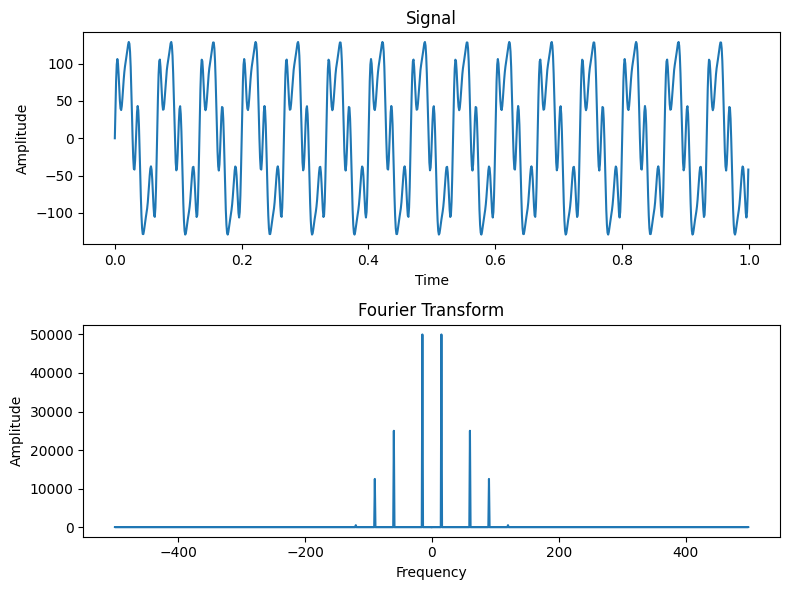

/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


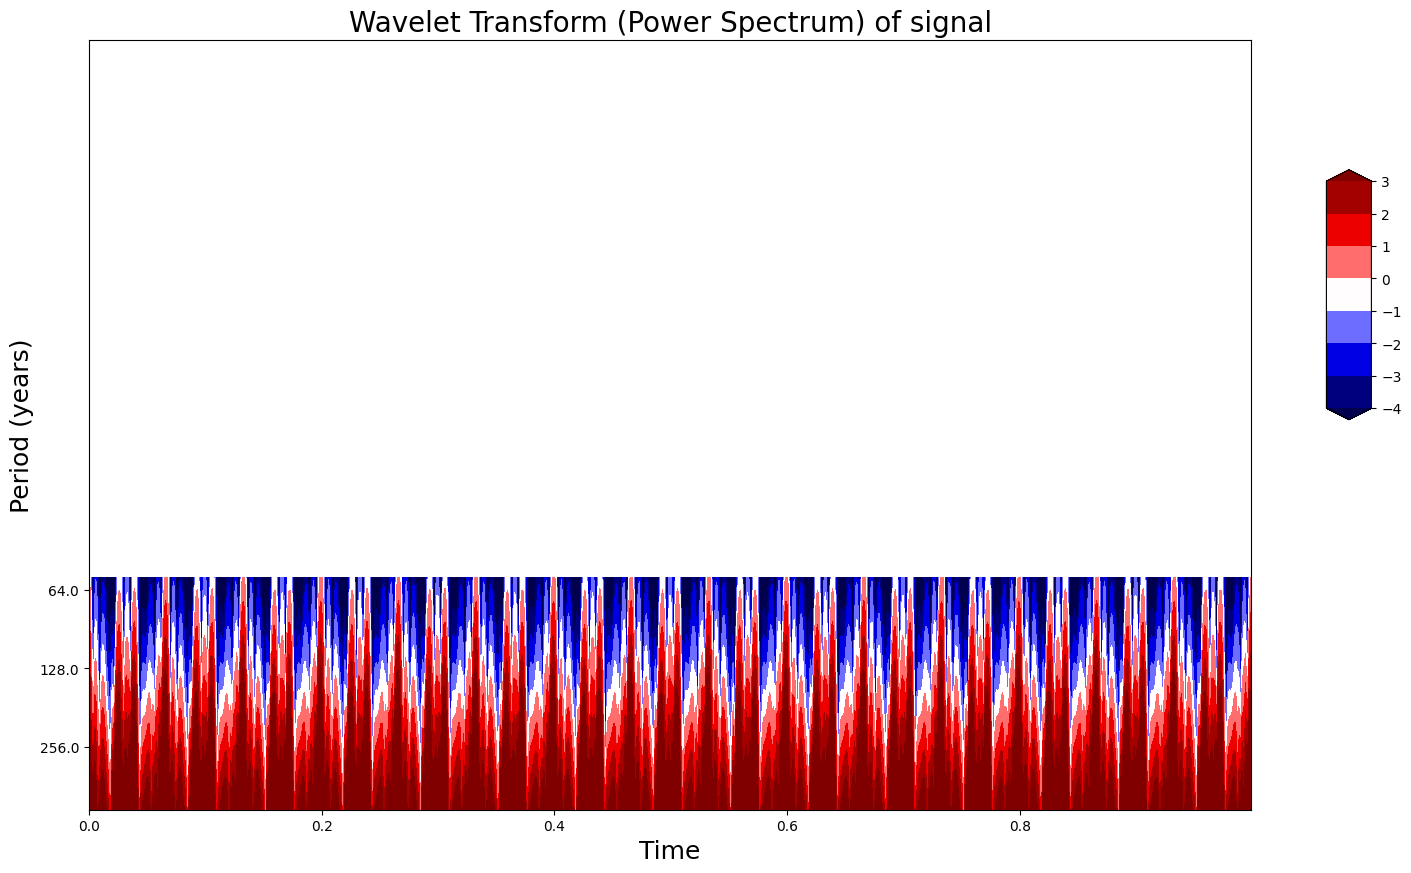

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Define the time and signal
T = 1.0  # Time period
N = 1000  # Number of samples
t = np.linspace(0, T, N, endpoint=False)  # Time vector
f1, f2, f3, f4 = 15, 60, 90 , 120 # Frequencies of the signal components
signal = 100 * np.sin(2 * np.pi * f1 * t) + 50 * np.sin(2 * np.pi * f2 * t) + 25 * np.sin(2 * np.pi * f3 * t) + 1 * np.sin(2 * np.pi * f4 * t) # Signal

# Calculate the Fourier transform
fft = np.fft.fft(signal)
freq = np.fft.fftfreq(N, 1.0 / N)  # Frequency vector

# Plot the signal and its Fourier transform
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(t, signal)
ax1.set_title('Signal')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')

ax2.plot(freq, np.abs(fft))
ax2.set_title('Fourier Transform')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()
scales = np.abs(np.log(np.array([1,2])+ 0.1))

plot_wavelet(t, signal, scales)

In [124]:
scales

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127])

In [46]:
plt.plot(data_set_train.T)

torch.Size([3399, 307])

In [1]:
import pywt
print(pywt.families(short=False))
# ['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 
# 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 
# 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']

['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


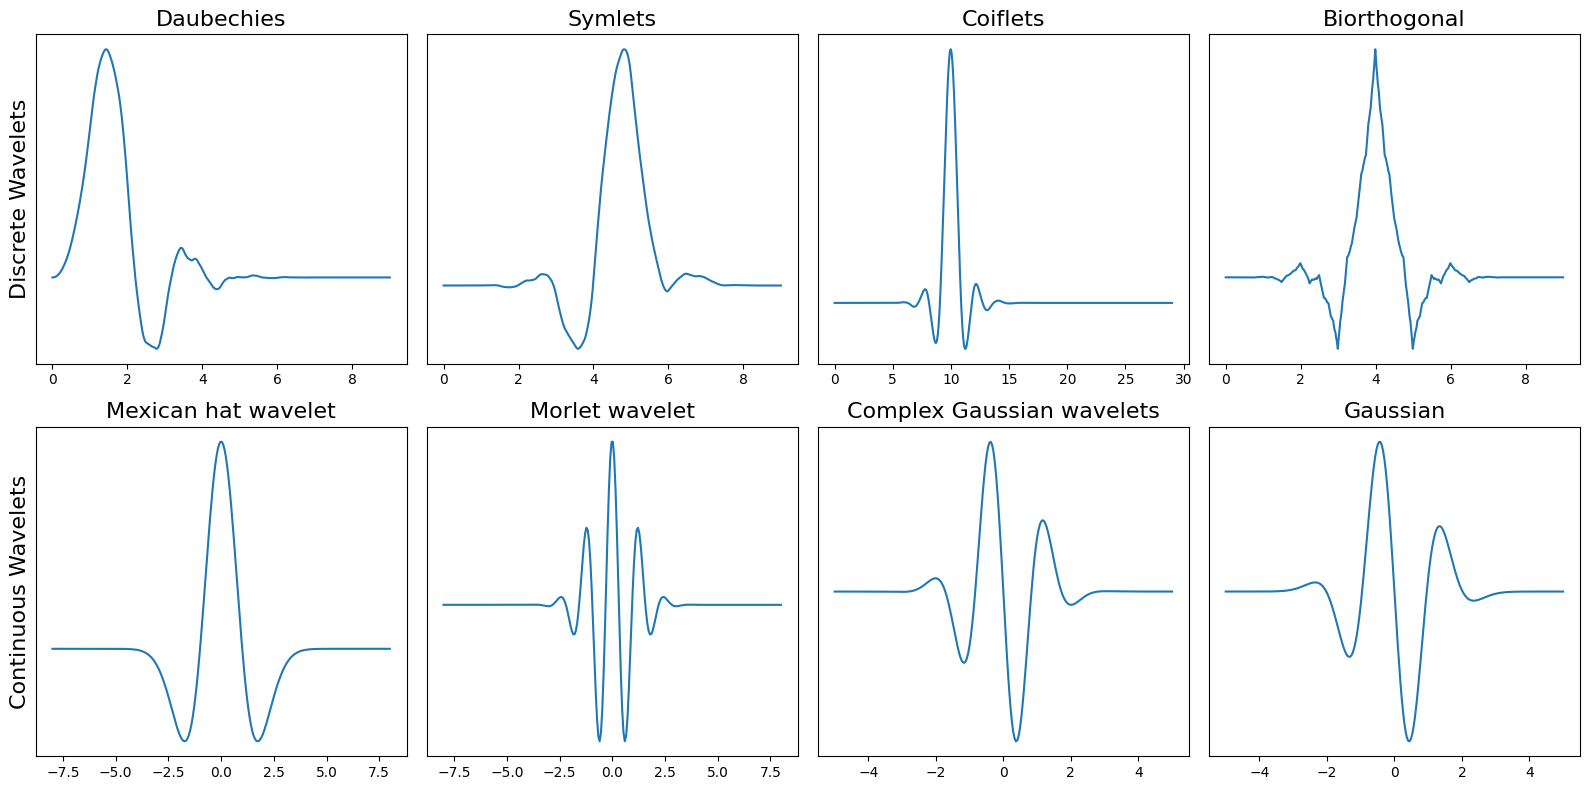

In [2]:
from matplotlib import pyplot as plt


discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']

list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]

fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        if ii == 0:
            _ = wavelet.wavefun()
            wavelet_function = _[0]
            x_values = _[-1]
        else:
            wavelet_function, x_values = wavelet.wavefun()
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=16)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=16)
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=16)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])

plt.tight_layout()
plt.show()

['db1', 'db2', 'db3', 'db4', 'db5']


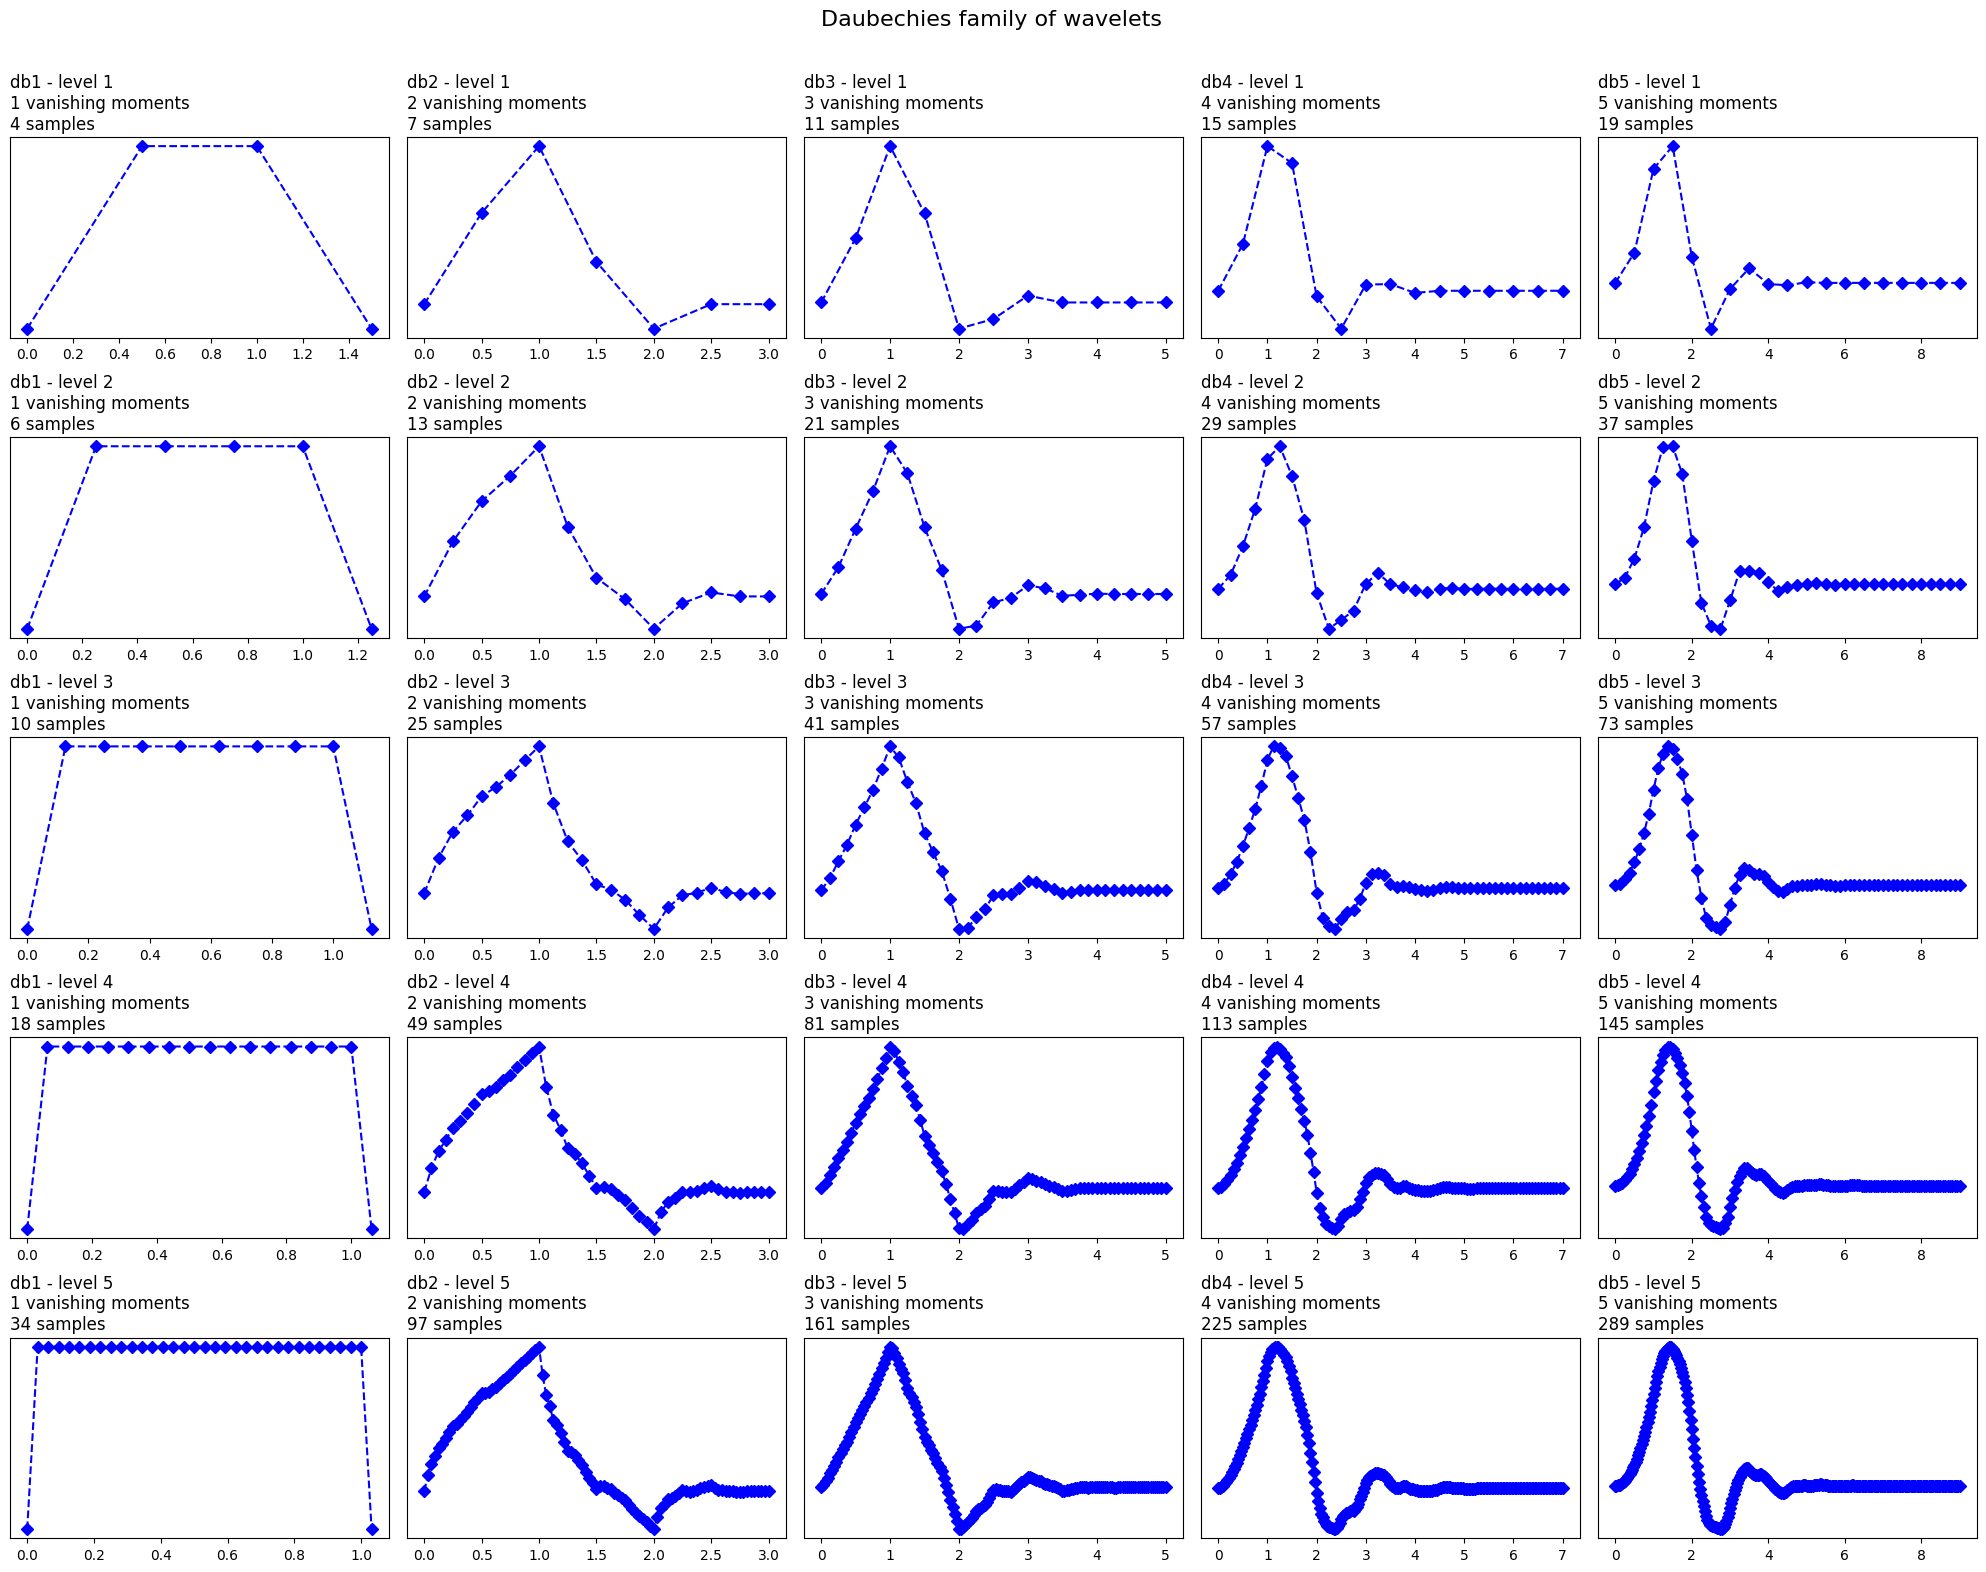

In [3]:
import pywt
import matplotlib.pyplot as plt

db_wavelets = pywt.wavelist('db')[:5]
print(db_wavelets)
# *** ['db1', 'db2', 'db3', 'db4', 'db5']

fig, axarr = plt.subplots(ncols=5, nrows=5, figsize=(20,16))
fig.suptitle('Daubechies family of wavelets', fontsize=16)
for col_no, waveletname in enumerate(db_wavelets):
    wavelet = pywt.Wavelet(waveletname)
    no_moments = wavelet.vanishing_moments_psi
    family_name = wavelet.family_name
    for row_no, level in enumerate(range(1,6)):
        wavelet_function, scaling_function, x_values = wavelet.wavefun(level = level)
        axarr[row_no, col_no].set_title("{} - level {}\n{} vanishing moments\n{} samples".format(
            waveletname, level, no_moments, len(x_values)), loc='left')
        axarr[row_no, col_no].plot(x_values, wavelet_function, 'bD--')
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

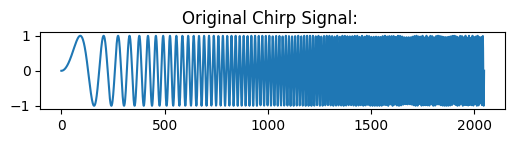

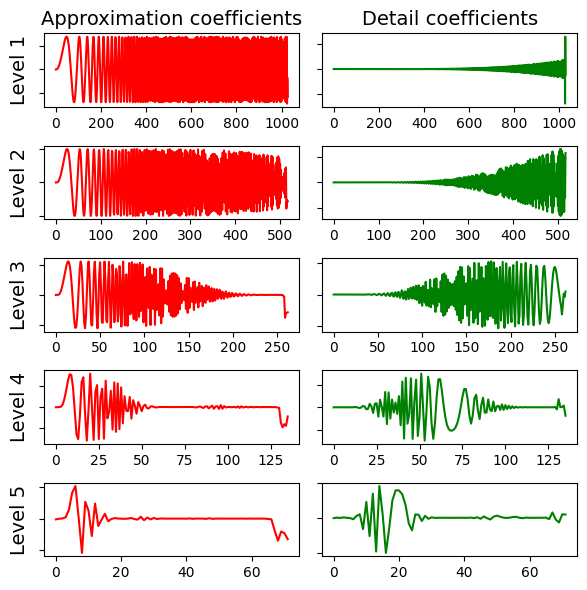

In [4]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import scipy

x = np.linspace(0, 1, num=2048)
chirp_signal = np.sin(250 * np.pi * x**2)
    
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Chirp Signal: ")
ax.plot(chirp_signal)
plt.show()
    
data = chirp_signal
waveletname = 'sym5'

fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

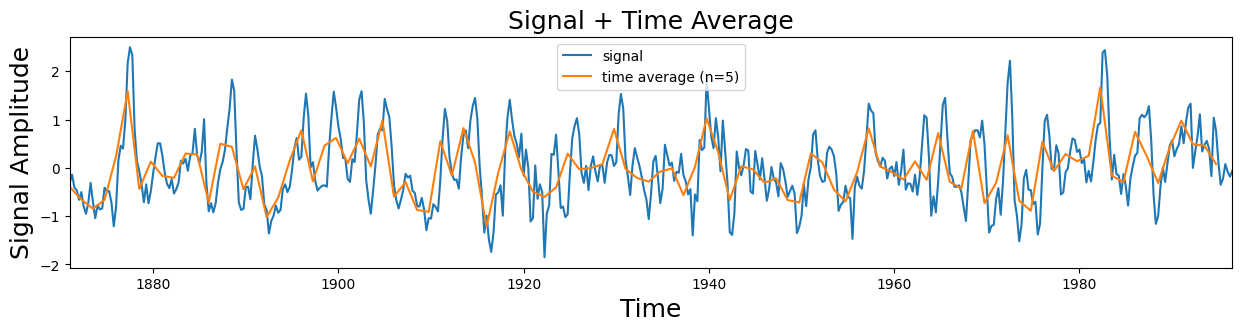

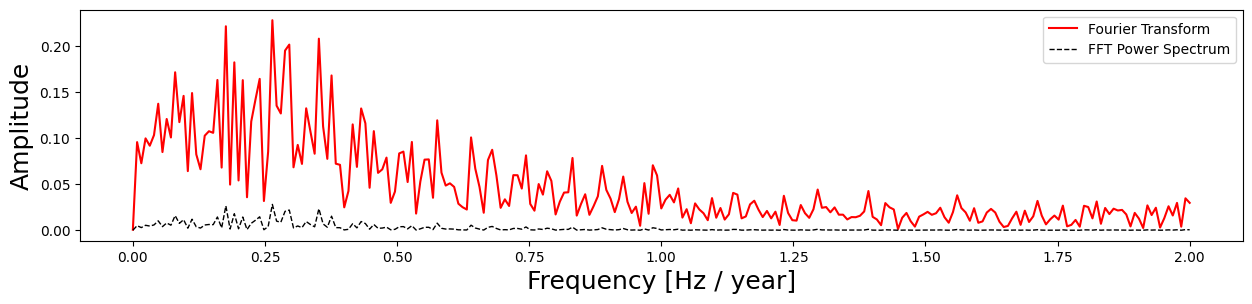

/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


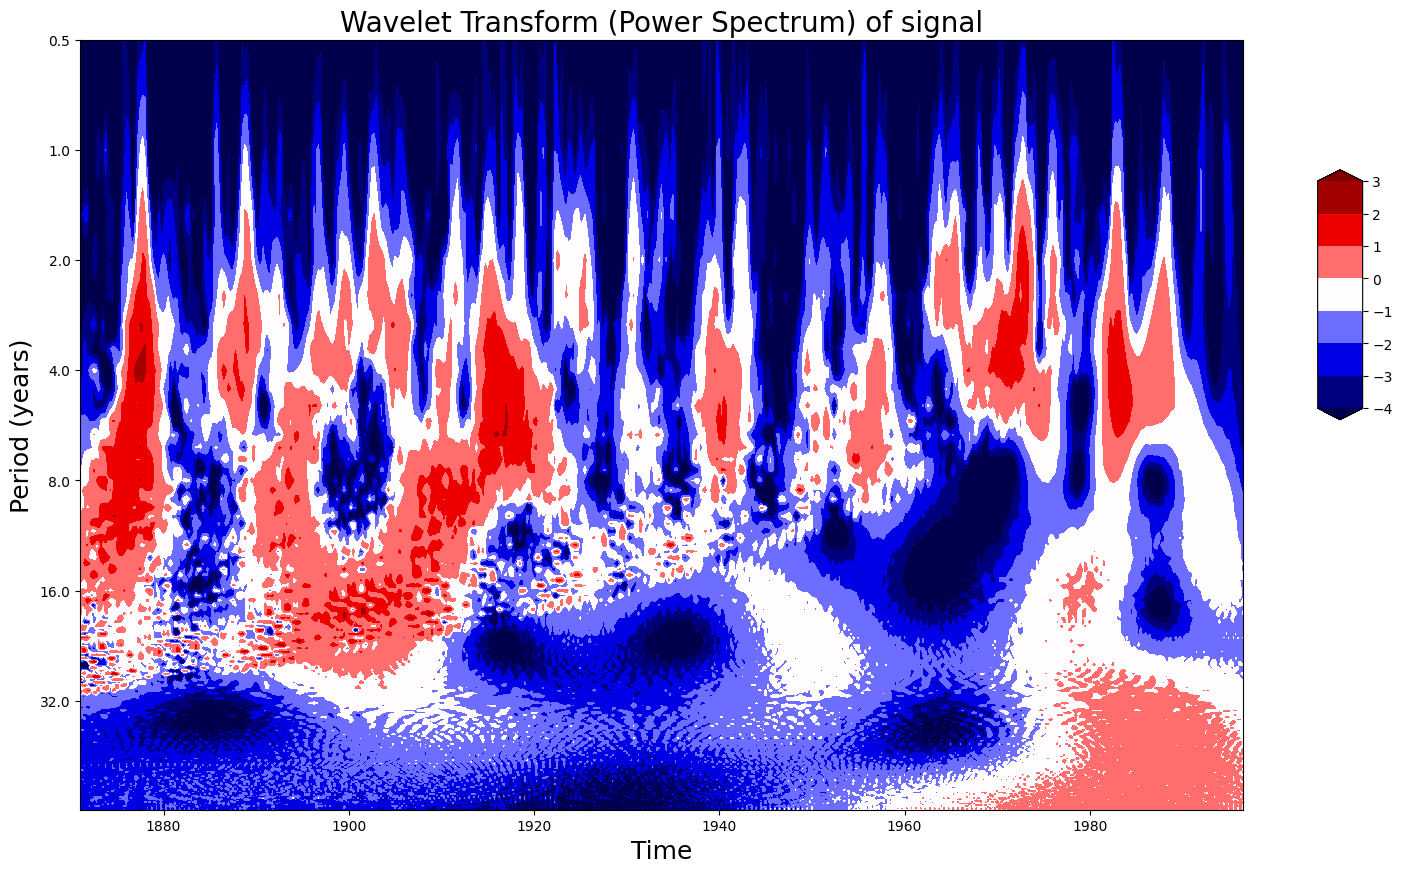

In [6]:


dataset = "http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat"
df_nino = pd.read_table(dataset)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()

scales = np.arange(1, 128)
plot_signal_plus_average(time, signal)
plot_fft_plus_power(time, signal)
plot_wavelet(time, signal, scales)

In [8]:
import os
def read_signals_ucihar(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels_ucihar(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return activities

def load_ucihar_data(folder):
    train_folder = folder + 'train/InertialSignals/'
    test_folder = folder + 'test/InertialSignals/'
    labelfile_train = folder + 'train/y_train.txt'
    labelfile_test = folder + 'test/y_test.txt'
    train_signals, test_signals = [], []
    for input_file in os.listdir(train_folder):
        signal = read_signals_ucihar(train_folder + input_file)
        train_signals.append(signal)
    train_signals = np.transpose(np.array(train_signals), (1, 2, 0))
    for input_file in os.listdir(test_folder):
        signal = read_signals_ucihar(test_folder + input_file)
        test_signals.append(signal)
    test_signals = np.transpose(np.array(test_signals), (1, 2, 0))
    train_labels = read_labels_ucihar(labelfile_train)
    test_labels = read_labels_ucihar(labelfile_test)
    return train_signals, train_labels, test_signals, test_labels

folder_ucihar = './data/UCI_HAR/' 
train_signals_ucihar, train_labels_ucihar, test_signals_ucihar, test_labels_ucihar = load_ucihar_data(folder_ucihar)

FileNotFoundError: [Errno 2] No such file or directory: './data/UCI_HAR/train/InertialSignals/'

In [ ]:
scales = range(1,128)
waveletname = 'morl'
train_size = 5000
test_size= 500

train_data_cwt = np.ndarray(shape=(train_size, 127, 127, 9))

for ii in range(0,train_size):
    if ii % 1000 == 0:
        print(ii)
    for jj in range(0,9):
        signal = uci_har_signals_train[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        train_data_cwt[ii, :, :, jj] = coeff_

test_data_cwt = np.ndarray(shape=(test_size, 127, 127, 9))
for ii in range(0,test_size):
    if ii % 100 == 0:
        print(ii)
    for jj in range(0,9):
        signal = uci_har_signals_test[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        test_data_cwt[ii, :, :, jj] = coeff_

uci_har_labels_train = list(map(lambda x: int(x) - 1, uci_har_labels_train))
uci_har_labels_test = list(map(lambda x: int(x) - 1, uci_har_labels_test))

x_train = train_data_cwt
y_train = list(uci_har_labels_train[:train_size])
x_test = test_data_cwt
y_test = list(uci_har_labels_test[:test_size])

In [ ]:
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 
history = History()

img_x = 127
img_y = 127
img_z = 9
input_shape = (img_x, img_y, img_z)

num_classes = 6
batch_size = 16
num_classes = 7
epochs = 10

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])

train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

# *** Epoch 1/10
# *** 5000/5000 [==============================] - 235s 47ms/step - loss: 0.3963 - acc: 0.8876 - val_loss: 0.6006 - val_acc: 0.8780
# *** Epoch 2/10
# *** 5000/5000 [==============================] - 228s 46ms/step - loss: 0.1939 - acc: 0.9282 - val_loss: 0.3952 - val_acc: 0.8880
# *** Epoch 3/10
# *** 5000/5000 [==============================] - 224s 45ms/step - loss: 0.1347 - acc: 0.9434 - val_loss: 0.4367 - val_acc: 0.9100
# *** Epoch 4/10
# *** 5000/5000 [==============================] - 228s 46ms/step - loss: 0.1971 - acc: 0.9334 - val_loss: 0.2662 - val_acc: 0.9320
# *** Epoch 5/10
# *** 5000/5000 [==============================] - 231s 46ms/step - loss: 0.1134 - acc: 0.9544 - val_loss: 0.2131 - val_acc: 0.9320
# *** Epoch 6/10
# *** 5000/5000 [==============================] - 230s 46ms/step - loss: 0.1285 - acc: 0.9520 - val_loss: 0.2014 - val_acc: 0.9440
# *** Epoch 7/10
# *** 5000/5000 [==============================] - 232s 46ms/step - loss: 0.1339 - acc: 0.9532 - val_loss: 0.2884 - val_acc: 0.9300
# *** Epoch 8/10
# *** 5000/5000 [==============================] - 237s 47ms/step - loss: 0.1503 - acc: 0.9488 - val_loss: 0.3181 - val_acc: 0.9340
# *** Epoch 9/10
# *** 5000/5000 [==============================] - 250s 50ms/step - loss: 0.1247 - acc: 0.9504 - val_loss: 0.2403 - val_acc: 0.9460
# *** Epoch 10/10
# *** 5000/5000 [==============================] - 238s 48ms/step - loss: 0.1578 - acc: 0.9508 - val_loss: 0.2133 - val_acc: 0.9300
# *** Train loss: 0.11115437872409821, Train accuracy: 0.959
# *** Test loss: 0.21326758581399918, Test accuracy: 0.93

In [ ]:
(cA1, cD1) = pywt.dwt(signal, 'db2', 'smooth')
reconstructed_signal = pywt.idwt(cA1, cD1, 'db2', 'smooth')

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(signal, label='signal')
ax.plot(reconstructed_signal, label='reconstructed signal', linestyle='--')
ax.legend(loc='upper left')
plt.show()

In [ ]:
coeffs = pywt.wavedec(signal, 'db2', level=8)
reconstructed_signal = pywt.waverec(coeffs, 'db2')

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(signal[:1000], label='signal')
ax.plot(reconstructed_signal[:1000], label='reconstructed signal', linestyle='--')
ax.legend(loc='upper left')
ax.set_title('de- and reconstruction using wavedec()')
plt.show()

In [ ]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) &gt; 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) &gt; np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

In [ ]:
import scipy.io as sio
def load_ecg_data(filename):
    raw_data = sio.loadmat(filename)
    list_signals = raw_data['ECGData'][0][0][0]
    list_labels = list(map(lambda x: x[0][0], raw_data['ECGData'][0][0][1]))
    return list_signals, list_labels


##########

filename = './data/ECG_data/ECGData.mat'
data_ecg, labels_ecg = load_ecg_data(filename)
training_size = int(0.6*len(labels_ecg))
train_data_ecg = data_ecg[:training_size]
test_data_ecg = data_ecg[training_size:]
train_labels_ecg = labels_ecg[:training_size]
test_labels_ecg = labels_ecg[training_size:]

In [ ]:
def get_uci_har_features(dataset, labels, waveletname):
    uci_har_features = []
    for signal_no in range(0, len(dataset)):
        features = []
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            list_coeff = pywt.wavedec(signal, waveletname)
            for coeff in list_coeff:
                features += get_features(coeff)
        uci_har_features.append(features)
    X = np.array(uci_har_features)
    Y = np.array(labels)
    return X, Y

def get_ecg_features(ecg_data, ecg_labels, waveletname):
    list_features = []
    list_unique_labels = list(set(ecg_labels))
    list_labels = [list_unique_labels.index(elem) for elem in ecg_labels]
    for signal in ecg_data:
        list_coeff = pywt.wavedec(signal, waveletname)
        features = []
        for coeff in list_coeff:
            features += get_features(coeff)
        list_features.append(features)
    return list_features, list_labels

X_train_ecg, Y_train_ecg = get_ecg_features(train_data_ecg, train_labels_ecg, 'db4')
X_test_ecg, Y_test_ecg = get_ecg_features(test_data_ecg, test_labels_ecg, 'db4')

X_train_ucihar, Y_train_ucihar = get_uci_har_features(train_signals_ucihar, train_labels_ucihar, 'rbio3.1')
X_test_ucihar, Y_test_ucihar = get_uci_har_features(test_signals_ucihar, test_labels_ucihar, 'rbio3.1')

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


cls = GradientBoostingClassifier(n_estimators=2000)
cls.fit(X_train_ecg, Y_train_ecg)
train_score = cls.score(X_train_ecg, Y_train_ecg)
test_score = cls.score(X_test_ecg, Y_test_ecg)
print("Train Score for the ECG dataset is about: {}".format(train_score))
print("Test Score for the ECG dataset is about: {.2f}".format(test_score))

### 

cls = GradientBoostingClassifier(n_estimators=2000)
cls.fit(X_train_ucihar, Y_train_ucihar)
train_score = cls.score(X_train_ucihar, Y_train_ucihar)
test_score = cls.score(X_test_ucihar, Y_test_ucihar)
print("Train Score for the UCI-HAR dataset is about: {}".format(train_score))
print("Test Score for the UCI-HAR dataset is about: {.2f}".format(test_score))

# *** Train Score for the ECG dataset is about: 1.0
# *** Test Score for the ECG dataset is about: 0.93
# *** Train Score for the UCI_HAR dataset is about: 1.0
# *** Test Score for the UCI-HAR dataset is about: 0.95

https://blog.faradars.org/%D8%AA%D8%A8%D8%AF%DB%8C%D9%84-%D9%85%D9%88%D8%AC%DA%A9/